In [1]:
# setup notebook if it is run on Google Colab, cwd = notebook file location
try:
    # change notebook_path if this notebook is in a different subfolder of Google Drive
    notebook_path = "Projects/QuantumFlow/notebooks"

    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)

    %tensorflow_version 2.x
    !pip install -q ruamel.yaml
except:
    pass

# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# setup paths and variables for shared code (../quantumflow) and data (../data)
import sys
sys.path.append('../')
data_dir = "../data"

# import shared code, must run 0_create_shared_project_files.ipynb first!
from quantumflow.generate_datasets import generate_potentials
from quantumflow.numerov_solver import *
from quantumflow.utils import load_hyperparameters, QFDataset, integrate, weizsaecker_pseudo_integrand, weizsaecker_pseudo_functional, weizsaecker_pseudo_functional_derivative, np_integrate, derivative_five_point, laplace_five_point

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Algortihm Analysis

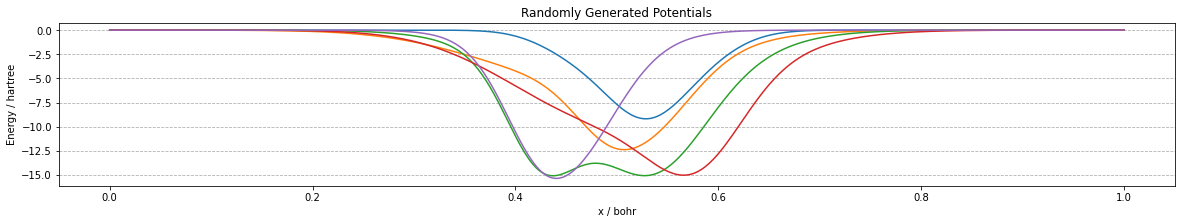

In [2]:
experiment = 'datasets'
analyse_name = "test"

preview = 5
analysis_dataset_size = 100
figsize = (20, 3)
dpi = None

params = load_hyperparameters(os.path.join(data_dir, experiment, "hyperparams.config"), run_name=analyse_name, globals=globals())

params['dataset_size'] = analysis_dataset_size

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx(params['dtype'])
tf.random.set_seed(params['seed'])

potential, x, h = generate_potentials(return_x=True, return_h=True, **params)
params['h'] = h

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(potential)[:, :preview]) # only plot first potentials
plt.title("Randomly Generated Potentials")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

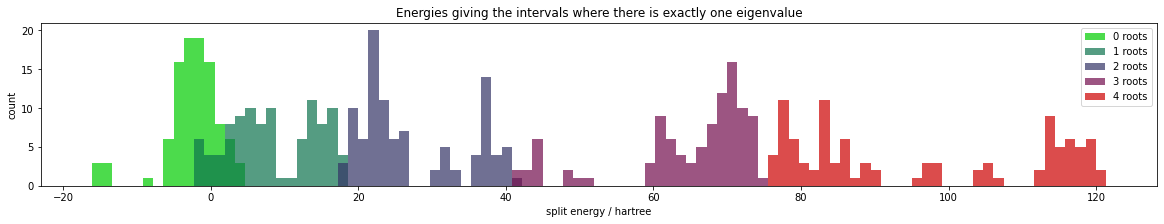

In [3]:
split_energies = find_split_energies(potential, params).numpy()

plt.figure(figsize=figsize, dpi=dpi)
bins = np.linspace(min(split_energies.flatten()), max(split_energies.flatten()), 100)

for i in range(split_energies.shape[1]):
    color = i/(split_energies.shape[1] - 1)
    plt.hist(split_energies[:, i], bins, alpha=0.7, color=[0.8*color**2, 0.8*(1-color)**2, 1.6*color*(1-color)], label= str(i) + " roots")

plt.xlabel('split energy / hartree')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title("Energies giving the intervals where there is exactly one eigenvalue")
plt.show()

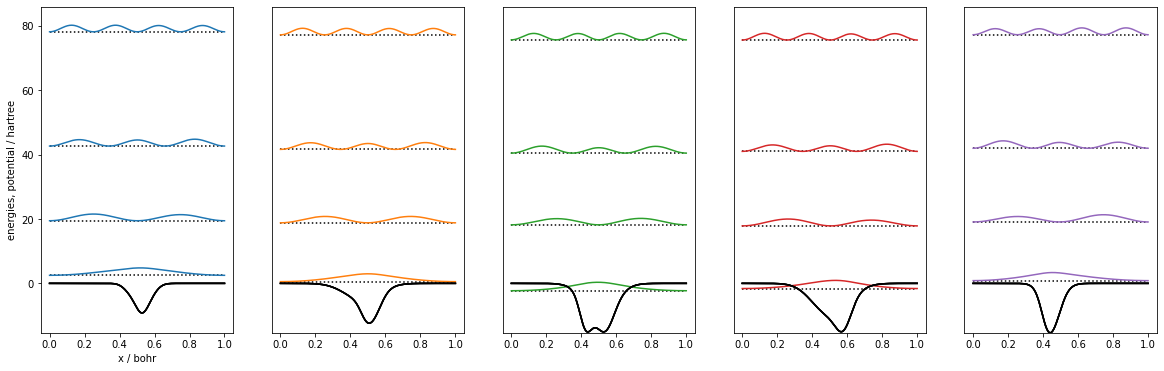

In [4]:
energies, wavefunctions = solve_schroedinger(potential, params)

fig, axs = plt.subplots(1, preview, figsize=(figsize[0], figsize[1]*2), dpi=dpi)

for i, plot in enumerate(wavefunctions.numpy()[:preview]**2 + energies.numpy()[:preview, np.newaxis, :]):
    for n, plot_single in enumerate(plot.transpose()):
        axs[i].plot(x, potential[i], 'k')
        axs[i].plot(x, np.ones(x.shape)*energies[i, n], ':k')
        axs[i].plot(x, plot_single, 'C' + str(i%10))
        axs[i].set_ylim([np.min(potential.numpy()[:preview]), max(np.max(energies.numpy()[:preview]*1.1), 0.5)])
        if i == 0: 
            axs[i].set_ylabel('energies, potential / hartree')
            axs[i].set_xlabel("x / bohr")
        else:
            axs[i].get_yaxis().set_visible(False)
#fig.suptitle('Numerov Solution Energies and Densities')
plt.show()

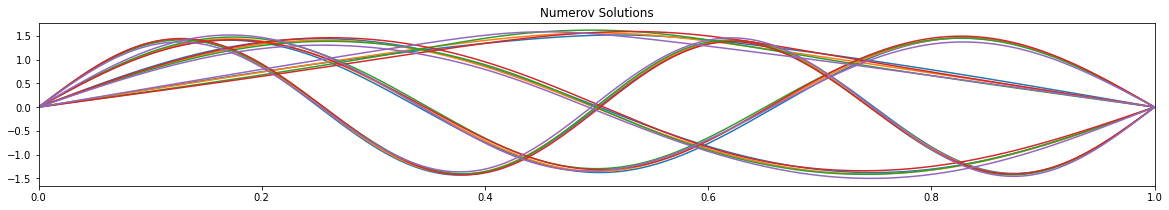

In [5]:
plt.figure(figsize=figsize, dpi=dpi)
for i, plot in enumerate(wavefunctions[:preview]):
    plt.plot(x, plot, 'C' + str(i%10))
plt.xlim(x.numpy()[[0, -1]])
plt.title('Numerov Solutions')
plt.show()

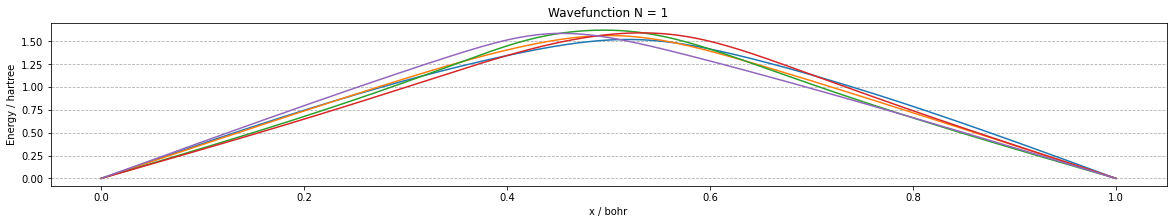

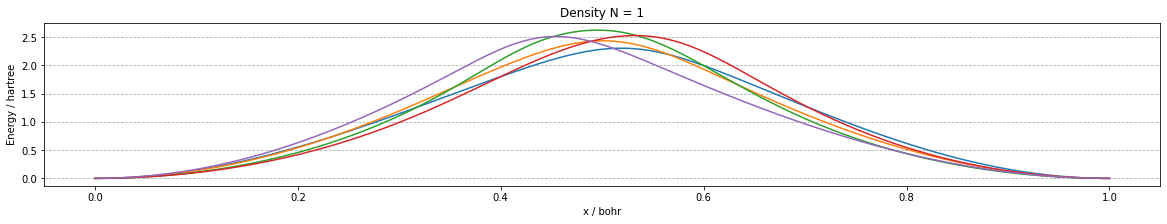

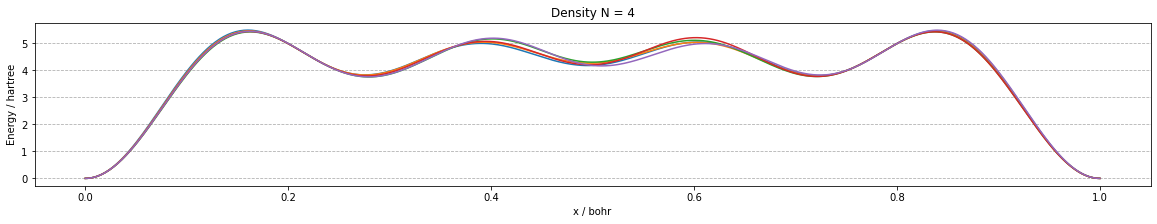

In [6]:
densities = wavefunctions**2
total_density = tf.reduce_sum(densities, axis=2)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(wavefunctions[:, :, 0])[:, :preview])
plt.title("Wavefunction N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(densities[:, :, 0])[:, :preview])
plt.title("Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(total_density)[:, :preview])
plt.title("Density N = {}".format(params['n_orbitals']))
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

In [0]:
laplace_wavefunctions = laplace_five_point(wavefunctions, params['h'])
kinetic_energy_densities = -0.5*wavefunctions*laplace_wavefunctions

kinetic_energies = integrate(kinetic_energy_densities, params['h'])

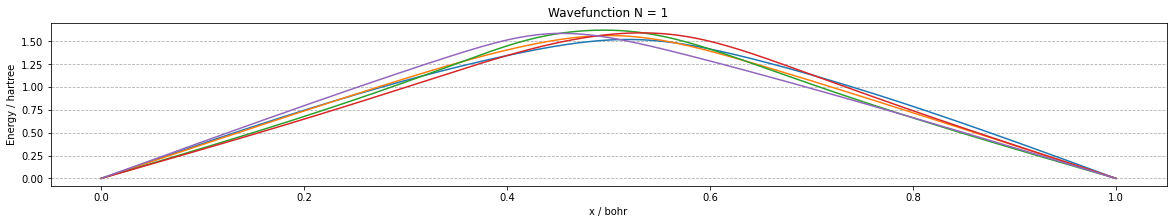

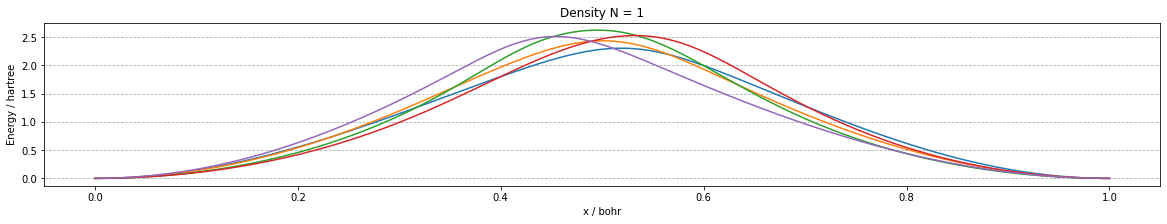

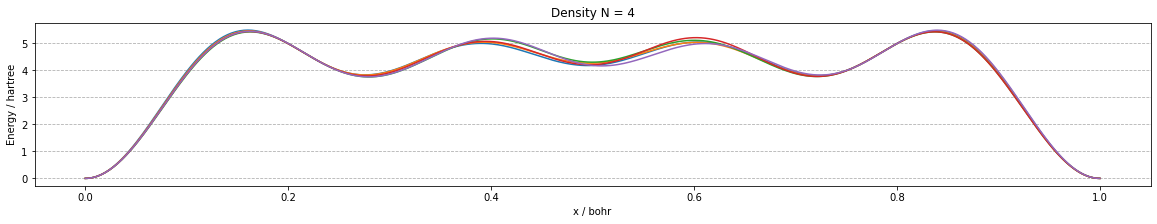

In [8]:
densities = wavefunctions**2
total_density = tf.reduce_sum(densities, axis=2)

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(wavefunctions[:, :, 0])[:, :preview])
plt.title("Wavefunction N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(densities[:, :, 0])[:, :preview])
plt.title("Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(total_density)[:, :preview])
plt.title("Density N = {}".format(params['n_orbitals']))
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

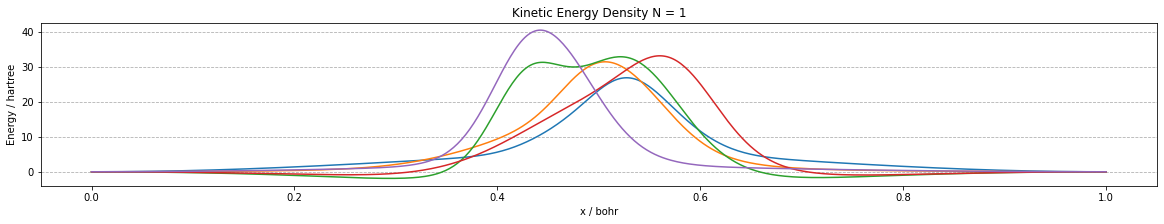

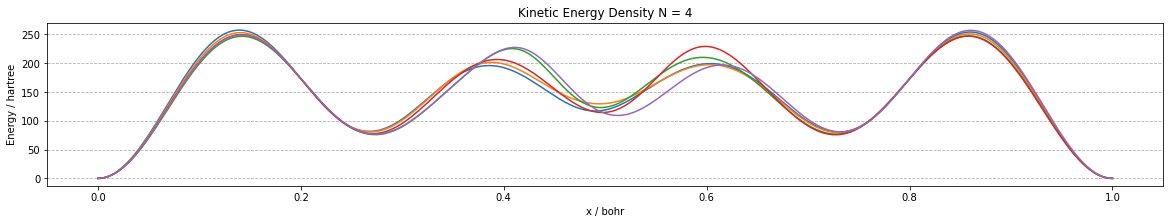

In [9]:
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities[:, :, 0])[:, :preview])
plt.title("Kinetic Energy Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(tf.reduce_sum(kinetic_energy_densities, axis=2))[:, :preview])
plt.title("Kinetic Energy Density N = {}".format(params['n_orbitals']))
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

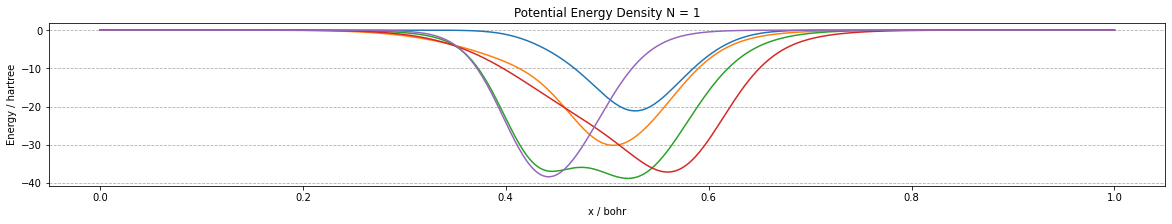

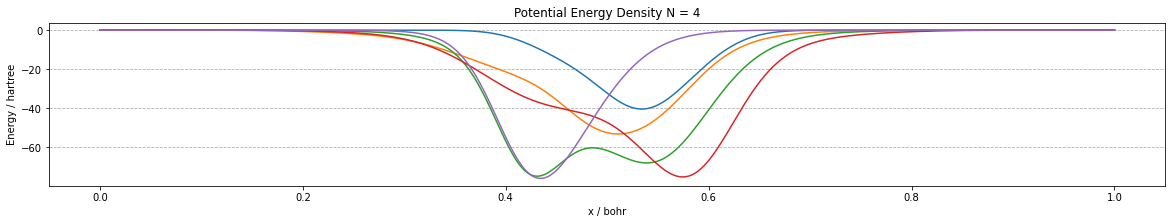

In [10]:
potential_energy_densities = tf.expand_dims(potential, axis=2)*wavefunctions**2
potential_energies = integrate(potential_energy_densities, params['h'])

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(potential_energy_densities[:, :, 0])[:, :preview])
plt.title("Potential Energy Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(tf.reduce_sum(potential_energy_densities, axis=2))[:, :preview])
plt.title("Potential Energy Density N = {}".format(params['n_orbitals']))
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


N=1 energy:                  [ 2.49898928  0.53541226 -2.28780193 -1.6042367   0.84889337]
N=1 potential energy:        [-2.5829723  -4.70089893 -7.90641158 -7.05082674 -4.51746416]
N=1 kinetic energy:          [5.08196158 5.23631119 5.61860964 5.44659003 5.36635753]
N=1 kinetic energy indirect: [5.08196158 5.23631119 5.61860964 5.44659004 5.36635753]


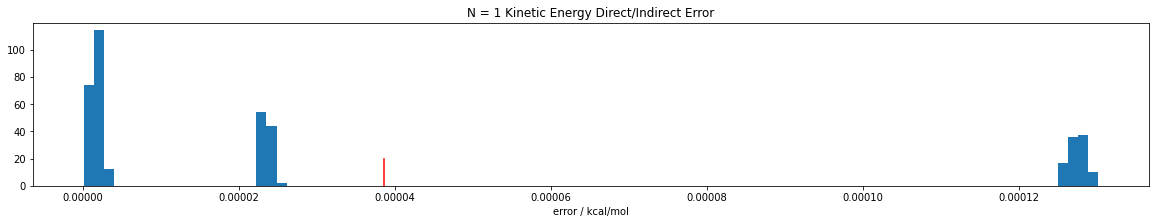

In [11]:
kcalmol_per_hartree = 627.51
kinetic_energies_indirect = energies - potential_energies

print('N=1 energy:                 ', energies[:preview, 0].numpy())
print('N=1 potential energy:       ', potential_energies[:preview, 0].numpy())
print('N=1 kinetic energy:         ', kinetic_energies[:preview, 0].numpy())
print('N=1 kinetic energy indirect:', kinetic_energies_indirect[:preview, 0].numpy())

err = np.abs(kinetic_energies - kinetic_energies_indirect).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size']*params['n_orbitals'])], 'r')
plt.title("N = 1 Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()

total energy:                  [142.76434047 138.17806636 132.00939328 132.85400002 139.14324729]
total potential energy:        [ -5.36372642 -10.03402904 -16.40962089 -15.44848231  -9.10973948]
total kinetic energy direct:   [148.12806665 148.21209517 148.41901392 148.30248208 148.25298652]
total kinetic energy indirect: [148.12806689 148.21209541 148.41901417 148.30248233 148.25298677]


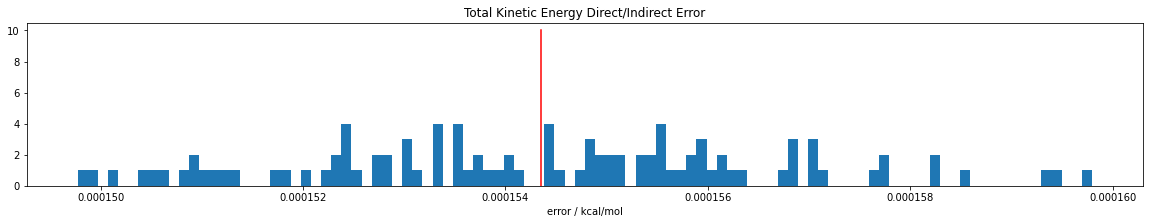

In [12]:
total_energy = tf.reduce_sum(energies, axis=-1)
print('total energy:                 ', total_energy[:preview].numpy())

potential_energy = tf.reduce_sum(potential_energies, axis=-1)
print('total potential energy:       ', potential_energy[:preview].numpy())

kinetic_energy = tf.reduce_sum(kinetic_energies, axis=-1)
print('total kinetic energy direct:  ', kinetic_energy[:preview].numpy())

kinetic_energy_indirect = tf.reduce_sum(kinetic_energies_indirect, axis=-1)
print('total kinetic energy indirect:', kinetic_energy_indirect[:preview].numpy())

err = np.abs(kinetic_energy - kinetic_energy_indirect).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size'])], 'r')
plt.title("Total Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()

## Direct 5-point stencil method

total kinetic energy 5     : [148.12806721 148.21209571 148.41901443 148.30248259 148.25298706]


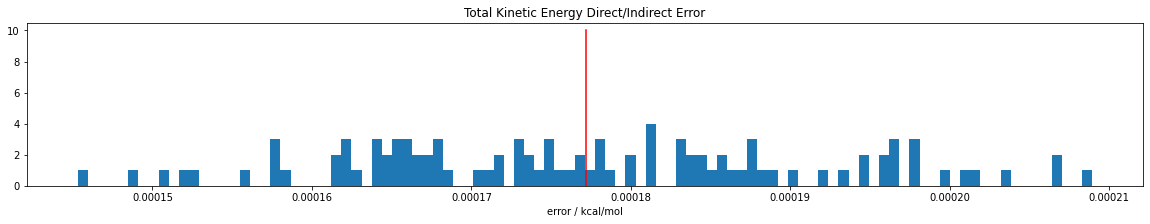

In [13]:
def laplace_5(wavefunctions, h):
    lpwf = 1/(12*h**2)*(-wavefunctions[:, 4:] + 16*wavefunctions[:, 3:-1] - 30*wavefunctions[:, 2:-2] + 16*wavefunctions[:, 1:-3] - wavefunctions[:, 0:-4])
    return tf.concat([3*lpwf[:, 0:1] - 2*lpwf[:, 1:2], 2*lpwf[:, 0:1] - lpwf[:, 1:2], lpwf, 2*lpwf[:, -1:] - lpwf[:, -2:-1], 3*lpwf[:, -1:] - 2*lpwf[:, -2:-1]], axis=1)

laplace_wavefunctions_5 = laplace_5(wavefunctions, params['h'])
kinetic_energy_densities_5 = -0.5*wavefunctions*laplace_wavefunctions_5

kinetic_energies_5 = integrate(kinetic_energy_densities_5, params['h'])

kinetic_energy_5 = tf.reduce_sum(kinetic_energies_5, axis=-1)
print('total kinetic energy 5     :', kinetic_energy_5[:preview].numpy())

err = np.abs(kinetic_energy_indirect - kinetic_energy_5).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size'])], 'r')
plt.title("Total Kinetic Energy Direct/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()


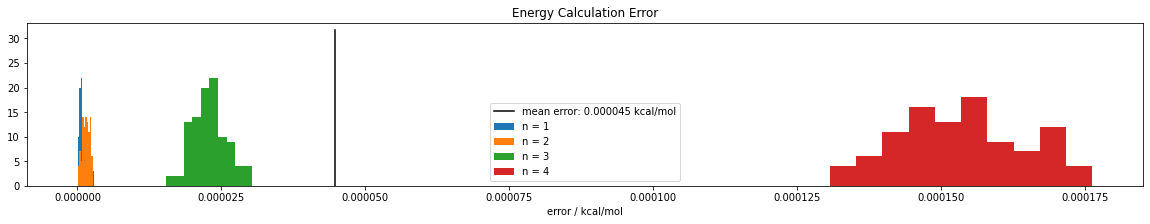

In [14]:
direct_energies = potential_energies + kinetic_energies_5

kcalmol_per_hartree = 627.51
err = np.abs(energies - direct_energies)*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err[:, 0], bins=10, label='n = 1')
plt.hist(err[:, 1], bins=10, label='n = 2')
plt.hist(err[:, 2], bins=10, label='n = 3')
plt.hist(err[:, 3], bins=10, label='n = 4')
plt.plot([np.mean(err.flatten()), np.mean(err.flatten())], [0, np.sqrt(1000)], 'k' ,label='mean error: {:.06f} kcal/mol'.format(np.mean(err.flatten())))
plt.title("Energy Calculation Error")
plt.xlabel('error / kcal/mol')
plt.legend()
plt.show()

#Alternative Kinetic Energy Density Formula

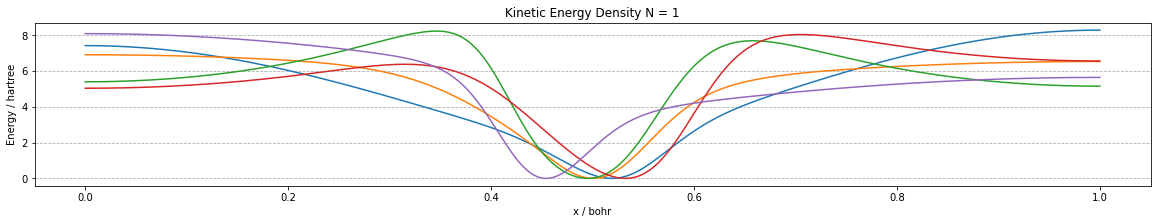

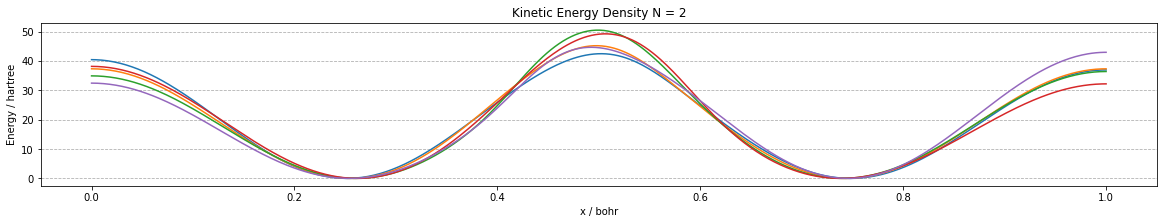

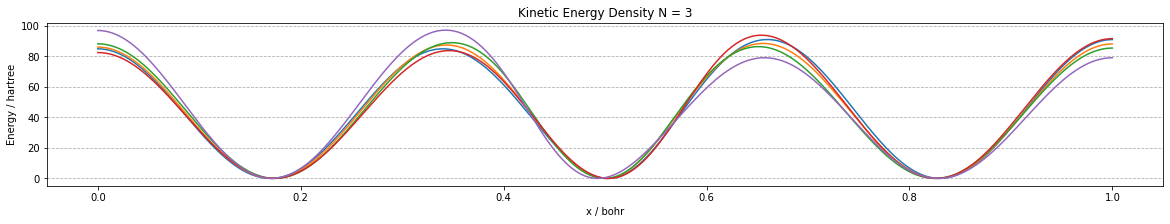

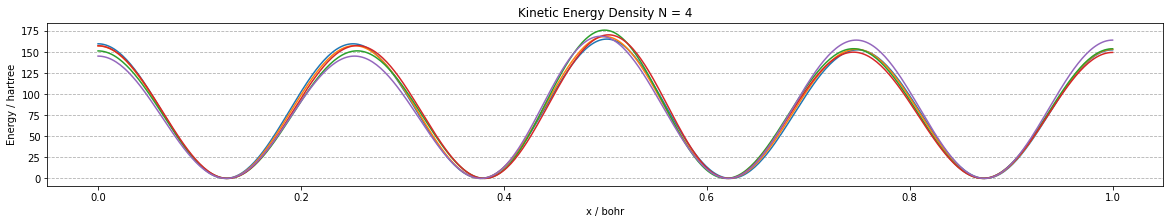

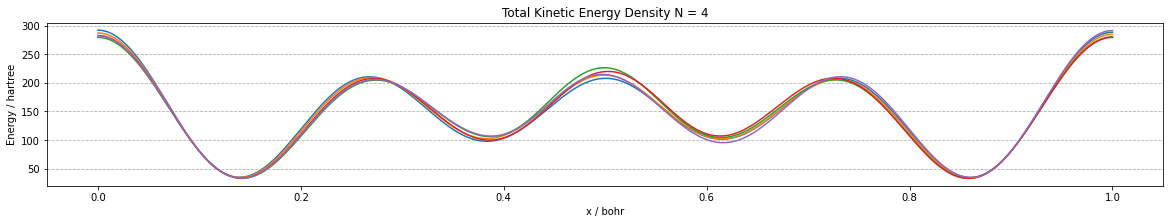

total kinetic energy 2     : [148.12806721 148.21209571 148.41901443 148.30248259 148.25298706]


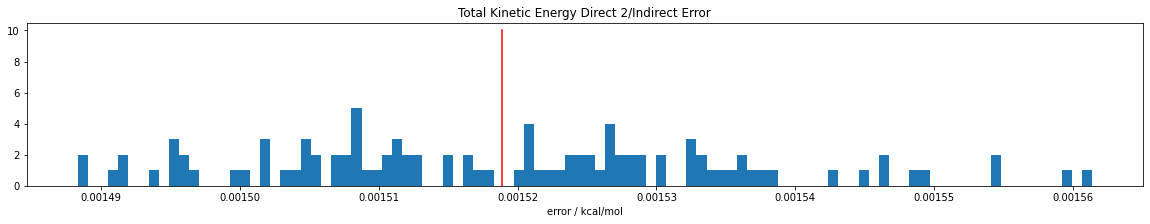

In [15]:
derivative_wavefunctions = derivative_five_point(wavefunctions, params['h'])

kinetic_energy_densities_2 = 0.5*tf.square(derivative_wavefunctions)

kinetic_energies_2 = integrate(kinetic_energy_densities_2, params['h'])

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities_2[:, :, 0])[:, :preview])
plt.title("Kinetic Energy Density N = 1")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities_2[:, :, 1])[:, :preview])
plt.title("Kinetic Energy Density N = 2")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()



plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities_2[:, :, 2])[:, :preview])
plt.title("Kinetic Energy Density N = 3")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(kinetic_energy_densities_2[:, :, 3])[:, :preview])
plt.title("Kinetic Energy Density N = 4")
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()


plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, np.transpose(tf.reduce_sum(kinetic_energy_densities_2, axis=2))[:, :preview])
plt.title("Total Kinetic Energy Density N = {}".format(params['n_orbitals']))
plt.xlabel("x / bohr")
plt.ylabel("Energy / hartree")
plt.grid(which='major', axis='y', linestyle='--')
plt.show()

kinetic_energy_2 = tf.reduce_sum(kinetic_energies_2, axis=-1)
print('total kinetic energy 2     :', kinetic_energy_5[:preview].numpy())

err = np.abs(kinetic_energy_indirect - kinetic_energy_2).flatten()*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err, bins=100)
plt.plot([np.mean(err), np.mean(err)], [0, np.sqrt(params['dataset_size'])], 'r')
plt.title("Total Kinetic Energy Direct 2/Indirect Error")
plt.xlabel('error / kcal/mol')
plt.show()


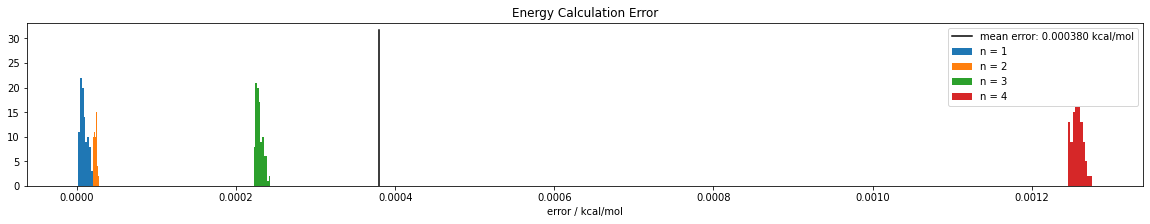

In [83]:
direct_energies = potential_energies + kinetic_energies_2

kcalmol_per_hartree = 627.51
err = np.abs(energies - direct_energies)*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err[:, 0], bins=10, label='n = 1')
plt.hist(err[:, 1], bins=10, label='n = 2')
plt.hist(err[:, 2], bins=10, label='n = 3')
plt.hist(err[:, 3], bins=10, label='n = 4')
plt.plot([np.mean(err.flatten()), np.mean(err.flatten())], [0, np.sqrt(1000)], 'k' ,label='mean error: {:.06f} kcal/mol'.format(np.mean(err.flatten())))
plt.title("Energy Calculation Error")
plt.xlabel('error / kcal/mol')
plt.legend()
plt.show()

# Numerical Analysis

In [0]:
import h5py

with h5py.File(os.path.join(data_dir, 'recreate/dataset_train.hdf5'), 'r') as f:
    x = f.attrs['x']
    h = f.attrs['h']
    potential = f['potential'][()]
    wavefunctions = f['wavefunctions'][()]
    energies = f['energies'][()]

with h5py.File(os.path.join(data_dir, 'recreate/dataset_fine.hdf5'), 'r') as f:
    x_fine = f.attrs['x']
    h_fine = f.attrs['h']
    potential_fine = f['potential'][()]
    wavefunctions_fine = f['wavefunctions'][()]
    energies_fine = f['energies'][()]


#with open(, 'rb') as f:
#    x, h, potential, wavefunctions, energies = pickle.load(f).values()

#with open(os.path.join(data_dir, 'recreate/dataset_fine.pkl'), 'rb') as f:
#    x_fine, h_fine, potential_fine, wavefunctions_fine, energies_fine = pickle.load(f).values()


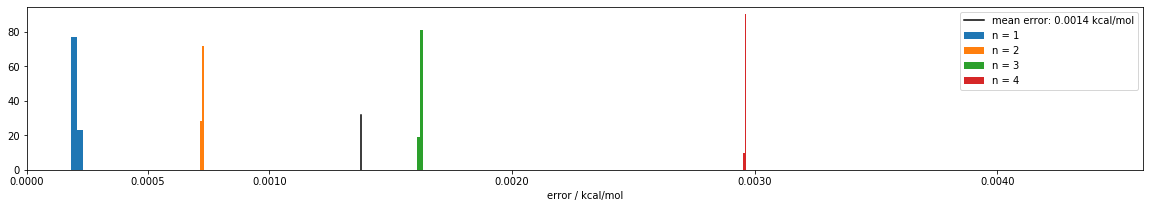

In [0]:
kcalmol_per_hartree = 627.51
err = np.abs(energies - energies_fine)*kcalmol_per_hartree
plt.figure(figsize=figsize, dpi=dpi)
plt.hist(err[:, 0], bins=2, label='n = 1')
plt.hist(err[:, 1], bins=2, label='n = 2')
plt.hist(err[:, 2], bins=2, label='n = 3')
plt.hist(err[:, 3], bins=2, label='n = 4')
plt.plot([np.mean(err.flatten()), np.mean(err.flatten())], [0, np.sqrt(1000)], 'k' ,label='mean error: {:.04f} kcal/mol'.format(np.mean(err.flatten())))
#plt.title("Energy Discretisation Error")
plt.xlabel('error / kcal/mol')
plt.xlim([0, 0.0046])
plt.xticks([0.0, 0.0005, 0.001, 0.002, 0.003, 0.004])
plt.legend()
plt.show()

#Analytical Kinetic Energy Lower Bound

In [0]:
def derivative(density, h):
    return 1/(2*h)*(tf.pad((density[:, 1:] - density[:, :-1]), [(0, 0), (0, 1)]) + tf.pad((density[:, 1:] - density[:, :-1]), [(0, 0), (1, 0)]))

def derivative_five_point(density, h):
    return tf.concat([1/(2*h)*(density[:, 2:3] - density[:, 0:1]), 
                      1/(12*h)*(-density[:, 4:] + 8*density[:, 3:-1] - 8*density[:, 1:-3] + density[:, 0:-4]),
                      1/(2*h)*(density[:, -1:] - density[:, -3:-2])], axis=1)

def laplace_five_point(density, h):
    return 1/(12*h**2)*(-density[:, 4:] + 16*density[:, 3:-1] - 30*density[:, 2:-2] + 16*density[:, 1:-3] - density[:, 0:-4])

def weizsaecker_functional(density, h):
    derivative_density = derivative_five_point(density, h)
    inverse_density = 1/density[:, 1:-1]

    weizsaecker_kinetic_energy_density = wked = 1/8*derivative_density**2*inverse_density
    weizsaecker_kinetic_energy_density = tf.concat([2*wked[:, 0:1] - wked[:, 1:2], wked, 2*wked[:, -1:] - wked[:, -2:-1]], axis=1)

    return integrate(weizsaecker_kinetic_energy_density, h)

def weizsaecker_functional_derivative(density, h):
    derivative_density = derivative_five_point(density, h)[:, 1:-1]
    laplace_density = laplace_five_point(density, h)
    inverse_density = 1/density[:, 2:-2]

    weizsaecker_kinetic_energy_functional_derivative = wkefd = 1/8*(derivative_density*inverse_density)**2 - 1/4*laplace_density*inverse_density
    weizsaecker_kinetic_energy_functional_derivative = tf.concat([3*wkefd[:, 0:1] - 2*wkefd[:, 1:2], 2*wkefd[:, 0:1] - wkefd[:, 1:2], wkefd, 2*wkefd[:, -1:] - wkefd[:, -2:-1], 3*wkefd[:, -1:] - 2*wkefd[:, -2:-1]], axis=1)

    return weizsaecker_kinetic_energy_functional_derivative


In [0]:
N = 1

deviation = 0.05*np.repeat(np.sin(x_fine[np.newaxis, :]*400*np.pi)**2, 100, axis=0)
#deviation = 0.01*np.random.randn(*potential_fine.shape)

density = np.sum(np.square(wavefunctions)[:, :, :N], axis=-1)*(1 + deviation[:, ::10])
density_fine = np.sum(np.square(wavefunctions_fine)[:, :, :N], axis=-1)*(1 + deviation)

kinetic_energy_lower_bound = weizsaecker_functional(density, h)
kinetic_energy_lower_bound_fine = weizsaecker_functional(density_fine, h_fine)

functional_derivative_lower_bound = weizsaecker_functional_derivative(density, h)
functional_derivative_lower_bound_fine = weizsaecker_functional_derivative(density_fine, h_fine)

offset = tf.expand_dims(tf.reduce_mean(functional_derivative_lower_bound + potential, axis=1), axis=1)

print('normal-fine:', np.mean(np.abs((kinetic_energy_lower_bound -  kinetic_energy_lower_bound_fine)*kcalmol_per_hartree)))

normal-fine: 142390.80956907294


In [0]:
potential_energy_densities_fine = np.expand_dims(potential_fine, axis=2)*wavefunctions_fine**2
potential_energies_fine = h_fine * (np.sum(potential_energy_densities_fine, axis=1) - 0.5 * (np.take(potential_energy_densities_fine, 0, axis=1) + np.take(potential_energy_densities_fine, -1, axis=1)))
kinetic_energies_fine = energies_fine - potential_energies_fine

energy_fine = np.sum(energies_fine[:, :N], axis=-1)
kinetic_energy = np.sum(kinetic_energies_fine[:, :N], axis=-1)

print('kinetic_energy:', kinetic_energy[:5])
print('kinetic_energy_lower_bound:', kinetic_energy_lower_bound[:5].numpy())
print('\n')

kenergies_err = np.abs(kinetic_energy - kinetic_energy_lower_bound.numpy())*kcalmol_per_hartree

print('MAE:', np.nanmean(kenergies_err))
print('AE_std:', np.std(kenergies_err))
print('AE_max:', np.max(kenergies_err))

kinetic_energy: [6.09802972 5.69350456 5.82912157 5.1002129  5.18103736]
kinetic_energy_lower_bound: [19.09287598 18.67853976 18.8174614  18.07078722 18.15342939]


MAE: 8144.532777716289
AE_std: 4.65273512426091
AE_max: 8157.811002659489


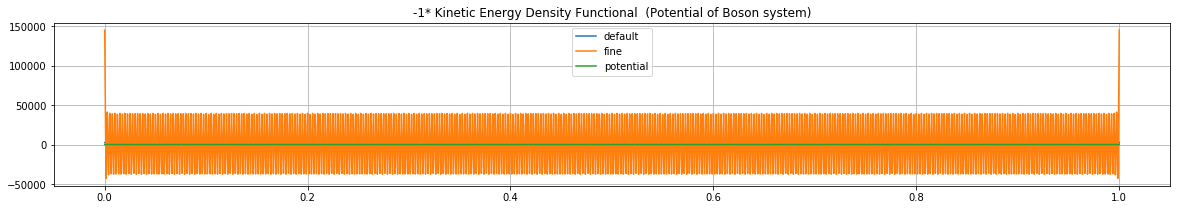

In [0]:
plt.figure(figsize=figsize, dpi=dpi)
plt.plot(x, -np.transpose(functional_derivative_lower_bound[0]), label="default")
plt.plot(x_fine, -np.transpose(functional_derivative_lower_bound_fine[0]), label="fine")
plt.plot(x, np.transpose(potential[0]-offset[0]), label="potential")
plt.legend()
plt.grid()
plt.title('-1* Kinetic Energy Density Functional  (Potential of Boson system)')
plt.show()

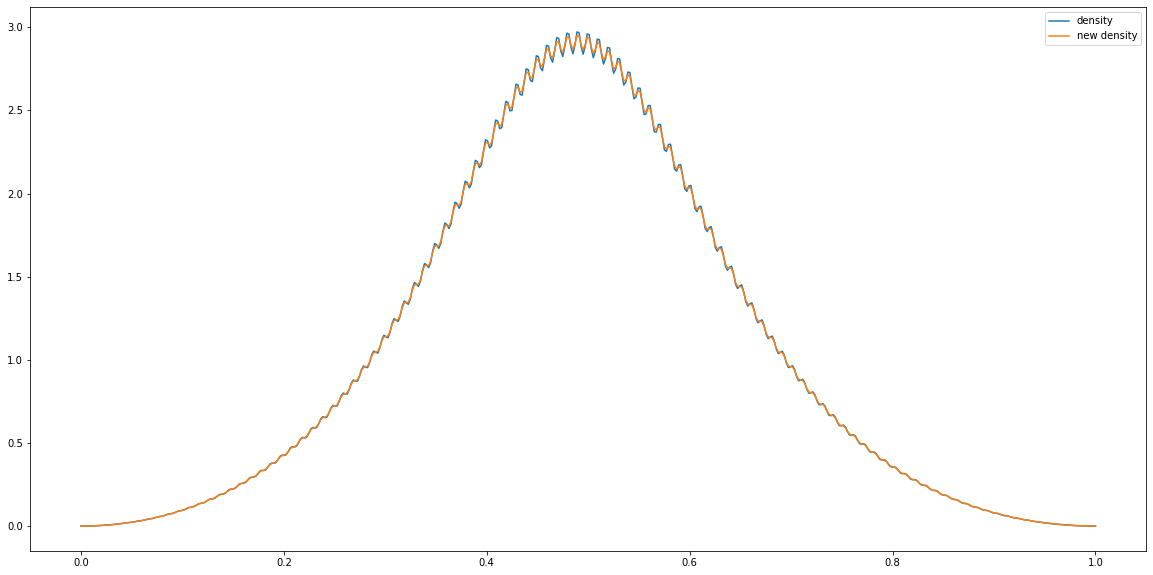

In [0]:
functional_derivative = potential + functional_derivative_lower_bound
new_density = density*np.exp(-0.000004*functional_derivative)
# normalise, voila!

plt.figure(figsize=(20, 10), dpi=dpi)
plt.plot(x, density[0], label="density")
plt.plot(x, new_density[0], label="new density")
#plt.plot(x, -0.01*functional_derivative[0], label="functional_derivative")
plt.legend()
plt.show()

# Correct \mu

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from quantumflow.utils import integrate
from quantumflow.numerov_solver import solve_schroedinger

params = load_hyperparameters(file_hyperparams, run_name='resnet_vW2', globals=globals())
dataset = QFDataset(os.path.join(data_dir, params['dataset_train']), params)
preview = 5

In [0]:
plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(dataset.density[:preview]))
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(dataset.potential[:preview]))
plt.show()

print(dataset.energy[:preview])

plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(dataset.derivative[:preview]))
plt.show()


In [0]:
potential_2 = -500*np.expand_dims(np.sin(2*np.pi*np.linspace(0, 1, 500, dtype=np.float64))**8, axis=0)
potential = np.concatenate([potential_2[0:1, :250], np.zeros(shape=(1, 250))], axis=1)

plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(potential))
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(potential_2))
plt.show()

energies, wavefunctions = solve_schroedinger(potential, params={'n_orbitals': 1, 'h': dataset.h, 'numerov_init_slope': 4, 'dtype': 'float64'})
energies_2, wavefunctions_2 = solve_schroedinger(potential_2, params={'n_orbitals': 2, 'h': dataset.h, 'numerov_init_slope': 4, 'dtype': 'float64'})

In [0]:
plt.figure(figsize=(20, 3))
plt.plot(dataset.x, wavefunctions[0])
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dataset.x, wavefunctions_2[0])
plt.show()

print(energies)
print(energies_2)
energy = np.sum(energies, axis=-1)
energy_2 = np.sum(energies_2, axis=-1)

density = np.sum(np.square(wavefunctions), axis=-1)
density_2 = np.sum(np.square(wavefunctions_2), axis=-1)

plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(density))
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(density_2))
plt.show()

In [0]:
derivative = np.expand_dims(energy, axis=1) - potential
derivative_2 = np.expand_dims(energy_2, axis=1)/2 - potential_2


plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(derivative))
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(derivative_2))
plt.show()

PI = derivative + potential
PI_2 = derivative_2 + potential_2

plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(PI))
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(PI_2))
plt.show()

In [0]:
from quantumflow.utils import weizsaecker_functional, weizsaecker_functional_derivative

vW_derivative = weizsaecker_functional_derivative(density, dataset.h)
vW_derivative_2 = weizsaecker_functional_derivative(density_2, dataset.h)

plt.figure(figsize=(20, 3))
plt.plot(dataset.x, np.transpose(derivative))
plt.plot(dataset.x, np.transpose(derivative_2))
plt.plot(dataset.x, np.transpose(vW_derivative))
plt.plot(dataset.x, np.transpose(vW_derivative_2))
plt.show()